# Parcial 3
### David Plazas Escudero - 201710005101

In [191]:
# Paquetes necesarios
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import cm, colors, rc
from sklearn.covariance import MinCovDet
from sklearn.covariance import LedoitWolf

np.random.seed(123456789)

%matplotlib inline
rc('text', usetex=True)
plt.rcParams.update({'font.size': 15})

folder_fig = "plts"
dir_fig = lambda x: os.path.join(folder_fig, x)

## 1. a)

In [171]:
# Lectura del archivo
file = open("vida.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)

data = np.array(data, dtype=np.float)

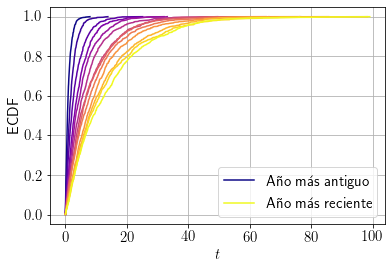

In [172]:
# Gráficas de Distribuciones Empíricas
color1 = plt.get_cmap('plasma')
color_norm = colors.Normalize(vmin=0, vmax=data.shape[1] - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
legends = {0: 'Año más antiguo', data.shape[1] - 1: 'Año más reciente'}
ecdfs = []
for i in range(data.shape[1]):
    color = scalar_map.to_rgba(i)
    ecdf = ECDF(data[:, i])
    ecdfs.append(ecdf)
    if i in legends.keys():
        plt.plot(ecdf.x, ecdf.y, color=color, label=legends[i])
    else:
        plt.plot(ecdf.x, ecdf.y, color=color)
plt.legend()
plt.grid()
plt.xlabel("$t$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("1a.pdf"), bbox_inches='tight')
plt.show()

## 1. b)

In [173]:
first_year = data[:, 0]
ecdf_first_year = ECDF(first_year)

alpha = 0.1
epsilon = np.sqrt(1 / (2 * data.shape[0]) * np.log(2 / alpha))

def bands(ecdf, epsilon, alpha=0.1):
    lower = np.zeros(len(ecdf.y))
    upper = np.zeros(len(ecdf.y))
    for i in range(len(ecdf.y)):
        lower[i] = max(ecdf.y[i] - epsilon, 0)
        upper[i] = min(ecdf.y[i] + epsilon, 1)
    return lower, upper

lower_first_year, upper_first_year = bands(ecdf_first_year, epsilon, alpha)

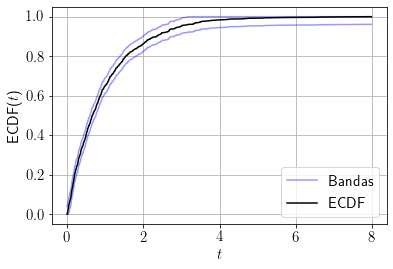

In [174]:
plt.plot(ecdf_first_year.x, lower_first_year, 'b', alpha=0.4, label='Bandas')
plt.plot(ecdf_first_year.x, upper_first_year, 'b', alpha=0.4)
plt.plot(ecdf_first_year.x, ecdf_first_year.y, 'k', label='ECDF')
plt.xlabel('$t$')
plt.ylabel('ECDF($t$)')
plt.legend()
plt.grid()
plt.savefig(dir_fig('1b.pdf'), bbox_inches='tight')
plt.show()

## 1. c)

### ECDFs

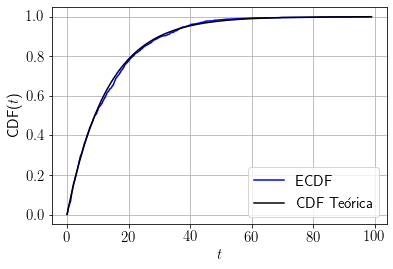

In [175]:
last_year = data[:, data.shape[1] - 1]
ecdf_ly = ECDF(last_year)
exp_cdf = st.expon.cdf(ecdf_ly.x, scale=13)
plt.plot(ecdf_ly.x, ecdf.y, 'b', label='ECDF')
plt.plot(ecdf_ly.x, exp_cdf, 'k', label='CDF Teórica')
plt.xlabel('$t$')
plt.ylabel('CDF($t$)')
plt.grid()
plt.legend()
plt.savefig(dir_fig('1c_1.pdf'), bbox_inches='tight')
plt.show()

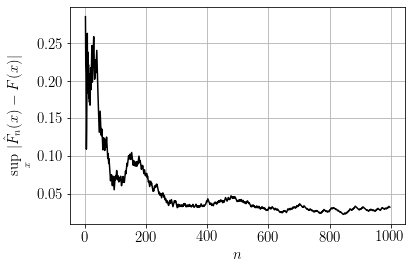

In [322]:
sups = []
ns = []
for n in range(2, 998, 1):
    ns.append(n)
    sample = last_year[:n]
    ecdf_n = ECDF(sample)
    cdf_n = st.expon.cdf(ecdf_n.x, scale=13)
    sups.append(np.max(np.abs(cdf_n - ecdf_n.y)))
    
plt.plot(ns, sups, 'k')
plt.xlabel("$n$")
plt.ylabel("$$\sup_x  \,|\hat{F}_n(x) - F(x)|$$")
plt.grid()
plt.savefig(dir_fig("1c_3.pdf"), bbox_inches='tight')
plt.show()

### Densidades

In [176]:
# method =
## 0 -> Uniform
## 1 -> Triangular
## 2 -> Epanechnikov
## 3 -> Bi-squared
## 4 -> Gaussian
def kernel_density(x, data, h, method=0):
    m = data.size
    u = (x - data) / h
    
    if h <= 0:
        h = data.std(ddof=1) * (4 / (3*m))**(1 / 5)
    ind = np.logical_and(-1 < u, u < 1).astype(np.int)
    if method == 0:
        I = 0.5 * ind
    elif method == 1:
        I = (1 - np.abs(u)) * ind
    elif method == 2:
        I = 0.75 * (1 - u ** 2) * ind
    elif method == 3:
        I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
    else:
        I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))
    
    return 1 / (m * h) * I.sum()

# Estimate the probability density function for a given sample
def estimate_density(sample, h, method=0, xs=None):
    if xs is None:
        xs = np.sort(sample)
    density = np.zeros(xs.size)
    i = 0
    for x in xs:
        density[i] = kernel_density(x, sample, h, method=method)
        i += 1
    return xs, density

exp_pdf = st.expon.pdf(ecdf_ly.x, scale=13)
x_pdf, estimated_pdf = estimate_density(last_year, 2, method=2)

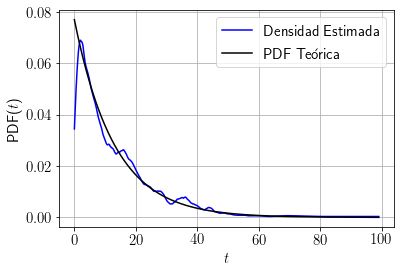

In [177]:
plt.plot(x_pdf, estimated_pdf, 'b', label='Densidad Estimada')
plt.plot(ecdf_ly.x, exp_pdf, 'k', label='PDF Teórica')
plt.xlabel('$t$')
plt.ylabel('PDF($t$)')
plt.grid()
plt.legend()
plt.savefig(dir_fig('1c_2.pdf'), bbox_inches='tight')
plt.show()

## 1. e)

In [324]:
# Normal Bootstrap method
def normal_interval(stats, alpha, og):
    aux = (stats - np.mean(stats)) ** 2
    v_boot = 1 / len(stats) * aux.sum()
    z_alpha = st.norm.ppf(1 - alpha / 2)
    interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))
        
    return interval, v_boot


# Percentile interval methods
def percentile_interval(stats, alpha, og):
    theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
    theta_alpha_sup = np.quantile(stats, alpha / 2)
    interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)
    
    return interval

    
# Studentized pivotal interval method
def studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og):
    if se_boot is None:
        aux = (stats - np.mean(stats)) ** 2
        se_boot = np.sqrt(1 / len(stats) * aux.sum())
    se_bs = []
    for sample in samples:
        _, add = bootstrap(sample, n, statistic, alpha=alpha, multi=multi)
        se_bs.append(np.sqrt(add['vboot']))
    z_star = []
    for i in range(len(se_bs)):
        z_star.append((stats[i] - og) / se_bs[i] )
        
    z_alpha_1 = np.quantile(z_star, 1 - alpha / 2)
    z_alpha = np.quantile(z_star, alpha / 2)
        
    interval = (og - z_alpha_1 * se_boot, og - z_alpha * se_boot)
    
    return interval

def pivotal_intervals(stats, alpha, og):
    theta_alpha = np.quantile(stats, 1 - alpha / 2)
    theta_alpha1 = np.quantile(stats, alpha / 2)
    
    interval = (2*og - theta_alpha, 2*og - theta_alpha1)
    
    return interval

# Bootstrap method
## 0 -> Normal interval
## 1 -> Percentile interval
## 2 -> Studentized pivotal interval
## 3 -> Pivotal intervals
def bootstrap(series, n, statistic, alpha=0.05, method=0, multi=False, se_boot=None):
    # Calculate the statistic
    samples = []
    if multi:
        indexes = np.array(range(series.shape[1]))
        for i in range(n):
            indexes0 = np.random.choice(indexes, size=series.shape[1])
            samples.append(np.array(list(map(lambda x: series[:, x], indexes0))))
    else:
        for i in range(n):
            samples.append(np.random.choice(series, size=len(series)))
    
    stats = np.array(list(map(lambda x: statistic(x), samples)))
    og = statistic(series)
    add = {}
    add['stats'] = stats

    # Calculate bootstrap respect the chosen method
    if method == 0:
        interval, v_boot = normal_interval(stats, alpha, og)
        add['vboot'] = v_boot
    elif method == 1:
        interval = percentile_interval(stats, alpha, og)
    elif method == 2:
        interval = studentized_pivotal_interval(stats, statistic, n, samples, se_boot, multi, alpha, og)
    elif method == 3:
        interval = pivotal_intervals(stats, alpha, og)
        
    return interval, add

# JackKnife method
def jackknife_bias(series, statistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    t_m = np.mean(stats)
    b_jack = (len(series) - 1) * (t_m - og)
    return b_jack

def jackknife_var(series, statistic, multi=False):
    # Calculate statistics
    og = statistic(series)
    stats = []
    if multi:
        size = series.shape[1]
        for i in range(series.shape[1]):
            rows = []
            for j in range(series.shape[0]):
                rows.append(np.concatenate((series[j, :i], series[j, (i+1):])))
            t_i = np.array(rows)
            stats.append(statistic(t_i))
    else:
        size = len(series)
        for i in range(len(series)):
            t_i = np.concatenate((series[:i], series[(i+1):]))
            stats.append(statistic(t_i))
    ti_v = size * og - (size - 1) * stats
    
    # Calculate variance
    s2 = ti_v.var(ddof=1)
    return s2 / size

In [334]:
stat = lambda x: x.max()

int_normal, _ = bootstrap(first_year, 10000, stat, method=0)
print('Normal Bootstrap CI:', int_normal)
int_percentile, _ = bootstrap(first_year, 10000, stat, method=1)
print('Percentile Bootstrap CI:', int_percentile)
int_studentized, _ = bootstrap(first_year, 1000, stat, method=2)
print('Studentized Bootstrap CI:', int_studentized)
int_pivotal, _ = bootstrap(first_year, 10000, stat, method=3)
print('Pivotal Bootstrap CI:', int_pivotal)

bias = jackknife_bias(first_year, stat)
var = jackknife_var(first_year, stat)
print('Jackknife Bias:', bias, ' Jackknife Var:', var)

Normal Bootstrap CI: (6.900508342197147, 9.064091657802853)
Percentile Bootstrap CI: (7.9823, 9.4068)
Studentized Bootstrap CI: (7.9823, 12.49002611593776)
Pivotal Bootstrap CI: (7.9823, 9.4068)
Jackknife Bias: -0.6563410230704676  Jackknife Var: 4.338154749167341e-07


## 1. f)

In [348]:
file = open("costos.txt").readlines()
costos = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    costos.append(row)

costos = np.array(costos, dtype=np.float)

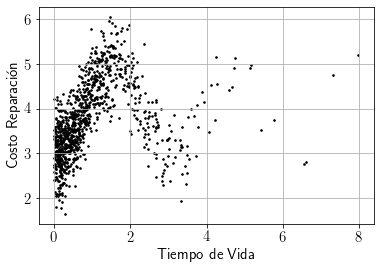

In [369]:
# Gráfico de Dispersión
plt.grid()
plt.scatter(first_year, costos, color='k', s=2.5)
plt.xlabel('Tiempo de Vida')
plt.ylabel('Costo Reparación')
plt.savefig(dir_fig('1f_scatter.pdf'), bbox_inches='tight')
plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.536
Model:                            OLS   Adj. R-squared (uncentered):              0.536
Method:                 Least Squares   F-statistic:                              1152.
Date:                Sat, 23 May 2020   Prob (F-statistic):                   2.16e-168
Time:                        20:20:54   Log-Likelihood:                         -2374.7
No. Observations:                 997   AIC:                                      4751.
Df Residuals:                     996   BIC:                                      4756.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

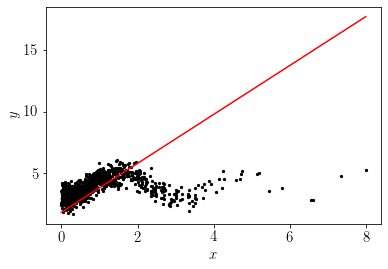

In [350]:
# Plot the regression model, given the estimated parameters.
def plot_regression_model(x, y, title, beta0, beta1):
    xs = np.linspace(x.min(), x.max(), 1000)
    ys = (beta0 + beta1 * xs).reshape(xs.size)
    plt.plot(xs, ys, "r")
    plt.scatter(x, y, color="k", s=5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.savefig(dir_fig(title), bbox_inches='tight')
    plt.show()
    

# Construct the regression model and plot the data with it's linear model.
def regression_model(x, y, title):
    # Fitting model
    model = sm.OLS(y, x)
    results = model.fit()
    print(results.summary())

    # Finding parameters
    beta1 = results.params
    beta0 = y.mean() - beta1 * x.mean()

    # Plotting
    plot_regression_model(x, y, title, beta0, beta1)
    
    return results

_ = regression_model(first_year, costos, '1f.pdf')

In [351]:
# method =
#   0 -> Uniform
#   1 -> Triangular
#   2 -> Epanechnikov
#   3 -> Bi-squared
#   4 -> Gaussian
def kernel_nw_regression(xs, ys, h, method=0):
   
    if h <= 0:
        h = xs.std(ddof=1) * (4 / (3*xs.size))**(1 / 5)
        
    est = np.zeros(xs.size)
    for j in range(xs.size):
        u = (xs[j] - xs) / h
        
        ind = np.logical_and(-1 < u, u < 1).astype(np.int)
        if method == 0:
            I = 0.5 * ind
        elif method == 1:
            I = (1 - np.abs(u)) * ind
        elif method == 2:
            I = 0.75 * (1 - u ** 2) * ind
        elif method == 3:
            I = (15 / 16) * (1 - 2 * u ** 2 + u ** 4) * ind
        else:
            I = ((1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u ** 2))

        denom = I.sum()
        num = I.dot(ys)
        est[j] = num / denom

    return est

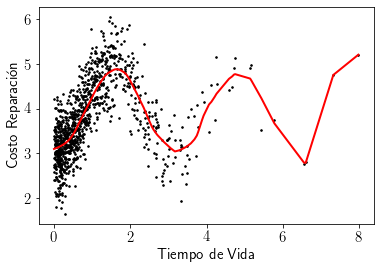

In [370]:
aux = np.array([first_year.reshape(997), costos.reshape(997)]).transpose().tolist()
aux = sorted(aux, key=lambda t: t[0])
aux = np.array(aux)

first_year_sorted = aux[:, 0]
costos_sorted = aux[:, 1]

first_year_sorted = np.sort(first_year)
nw_reg = kernel_nw_regression(first_year_sorted, costos_sorted, .5, method=2)

plt.scatter(first_year, costos, color='k', s=2.5, label='Datos')
plt.plot(first_year_sorted, nw_reg, 'r', label='Regresión N-W', linewidth=2)
plt.xlabel('Tiempo de Vida')
plt.ylabel('Costo Reparación')
plt.savefig(dir_fig('1f_nw.pdf'), bbox_inches='tight')
plt.show()

## 1. g)

In [183]:
# Wilcoxon ranksum test
results = np.ones((data.shape[1], data.shape[1]))
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i == j:
            continue
        _, results[i, j] = st.ranksums(data[:, i], data[:, j])

# Result of test
alpha = 0.05
print((results <= alpha).astype(np.int))

[[0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0]]


## 1. h)

### Primeros 400 registros

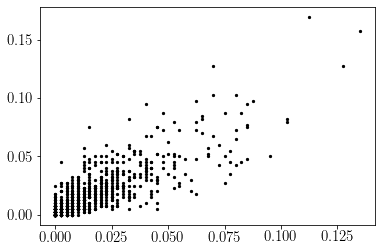

In [184]:
# Tukey statistical depth
def depth_tukey(point, data, n):
    r, c = data.shape
    
    u = np.random.normal(size=(c, n))
    
    # Calculate scalars
    scalar = data.dot(u)
    
    scalar2 = point.dot(u)
    
    replic = np.ones((r, 1)).dot(scalar2)
    diff = scalar - replic
    diff_indicator = (diff > 0).astype(np.int)
    
    return diff_indicator.mean(axis=0).min()

# D-D Plot
def ddplot(sample0, sample1, filename=None):
    others = []
    
    sample = np.array(sample0.tolist() + sample1.tolist())
    z_0 = np.zeros(sample.shape[0])
    z_1 = np.zeros(sample.shape[0])
    
    for i in range(sample.shape[0]):
        point = sample[i, :].reshape((1, sample.shape[1]))
        z_0[i] = depth_tukey(point, sample0, 500)
        z_1[i] = depth_tukey(point, sample1, 500)

        
    plt.scatter(z_0, z_1, s=5, color='k')
    
    if filename is not None:
        plt.savefig(dir_fig(filename), bbox_inches='tight')
    plt.show()
    
    return z_0, z_1

sample1 = data[:400, :]
sample2 = data[-400:, :]
z1, z2 = ddplot(sample1, sample2)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                              3225.
Date:                Sat, 23 May 2020   Prob (F-statistic):                   1.06e-282
Time:                        16:27:37   Log-Likelihood:                          2362.7
No. Observations:                 800   AIC:                                     -4723.
Df Residuals:                     799   BIC:                                     -4719.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

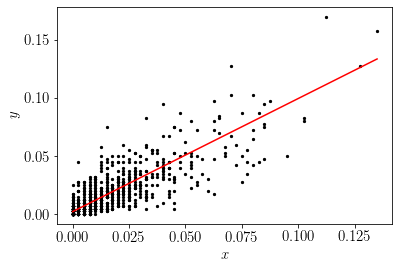

beta0 = [0.00236881] , beta1 = [0.97230136]


In [185]:
results_400 = regression_model(z1, z2, "1h_1.pdf")

beta1_400 = results_400.params
beta0_400 = z2.mean() - beta1_400 * z1.mean()
print('beta0 =', beta0_400, ', beta1 =', beta1_400)

### 5 primeros años

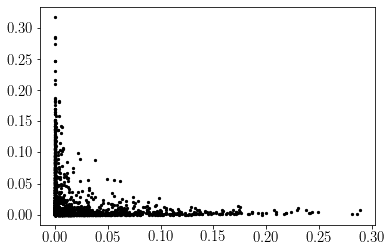

In [186]:
sample3 = data[:,:5]
sample4 = data[:, -5:]
z3, z4 = ddplot(sample3, sample4)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              6.138
Date:                Sat, 23 May 2020   Prob (F-statistic):                      0.0133
Time:                        16:28:10   Log-Likelihood:                          3426.4
No. Observations:                1994   AIC:                                     -6851.
Df Residuals:                    1993   BIC:                                     -6845.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

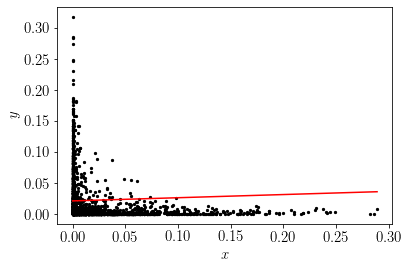

beta0 = [0.02164729] , beta1 = [0.05101102]


In [187]:
results_5 = regression_model(z3, z4, "1h_2.pdf")

beta1_5 = results_5.params
beta0_5 = z4.mean() - beta1_5 * z3.mean()
print('beta0 =', beta0_5, ', beta1 =', beta1_5)

In [298]:
betas = np.array([i for i in range(1, 14)][::-1]).reshape((13,1))
ruidos = np.random.normal(scale=50, size=(data.shape[0], 1))
y = (np.matmul(data, betas) + ruidos).reshape(y.shape[0])

In [378]:
# Generic method to convert from correlation matrix to covariance matrix
def corr_to_cov(data, correlation):
    stds = data.std(axis=0, ddof=1)

    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * stds[i] * stds[j]

    return cov

# Calculate comedian for two vectors
def comedian(u, v):
    median_u = np.quantile(u, 0.5)
    median_v = np.quantile(v, 0.5)
    
    aux = (u - median_u) * (v - median_v)
    
    return np.quantile(aux, 0.5)

# Calculate comedian matrix
def calculate_com(sample):
    com = np.zeros((sample.shape[1], sample.shape[1]))
    for i in range(sample.shape[1]):
        for j in range(sample.shape[1]):
            com[i, j] = comedian(sample[:, i], sample[:, j])
    
    return com

# method =
#    0 -> Spearman
#    1 -> Kendall
def calculate_cov_corr(sample, method=0):
    if method == 0:
        # Calculate Spearman
        spearman = pd.DataFrame(sample).corr(method="spearman").to_numpy()
        cov = corr_to_cov(sample, spearman)
    else:
        # Calculate Kendall
        kendall = pd.DataFrame(sample).corr(method="kendall").to_numpy()
        cov = corr_to_cov(sample, kendall)
    return cov


# Calculate covariance of MCD
def calculate_cov_MCD(sample):
    return MinCovDet().fit(sample).covariance_

# Calculate covariance of shrinkages
def calculate_cov_shrinkages(sample):
    return LedoitWolf().fit(sample).covariance_

# Calculate linear regression with different covariance matrix
#    method =
#       0 -> Comedian matrix
#       1 -> Spearman
#       2 -> Kendall
#       3 -> FastMCD
#       4 -> Shrinkages
def cov_linear_regression(x, y, method=0):
    if x.ndim == 1:
        x_aux = x.reshape((x.size, 1))
    else:
        x_aux = x
    
    method_1 = method - 1
    if method == 0:
        calculation = lambda matrix: calculate_com(matrix)
    elif method in range(1, 3):
        calculation = lambda matrix: calculate_cov_corr(matrix, method=method_1)
    elif method == 3:
        calculation = lambda matrix: calculate_cov_MCD(matrix)
    else:
        calculation = lambda matrix: calculate_cov_shrinkages(matrix)
    
    
    cov_x = calculation(x_aux)
    covs = []
    for i in range(x_aux.shape[1]):
        sample = np.array([x_aux[:,i], y]).transpose()
        
        cov_xy = calculation(sample)[1, 0]
        
        covs.append([cov_xy])
    covs = np.array(covs)
    
    betas = np.linalg.inv(cov_x).dot(covs)
    return betas

def plot_multvar_regression(y, x, betas, betas_og, method='Comediana'):
    beta0 = y.mean() - betas.transpose().dot(data.mean(axis=0).reshape((betas.shape[0], 1)))
    y_reg = x.dot(betas) + beta0
    
    print('Betas: ', betas.transpose(), '\n Beta0: ', beta0)
    print('Dif:', np.linalg.norm(betas-betas_og))
    
    linewidth = 0.9
    plt.figure(figsize=(15, 5))
    plt.plot(y, 'k', label='Datos', linewidth=linewidth)
    plt.plot(y_reg, 'r', label='Regresión ' + method, linewidth=linewidth)
    plt.ylabel('$y$')
    plt.xlim((-1, 998))
    plt.legend()
    plt.grid()
    plt.savefig(dir_fig('1i_' + method + '.pdf'), bbox_inches='tight')
    plt.show()

Betas:  [[ 8.66304518  8.65287206 11.17761184  9.08671475  7.84488272  7.62292981
   8.59853489  5.11751081  4.70115993  2.9717184   2.97197185  1.02467322
   0.3036609 ]] 
 Beta0:  [[50.88236652]]
Dif: 6.186457936546276


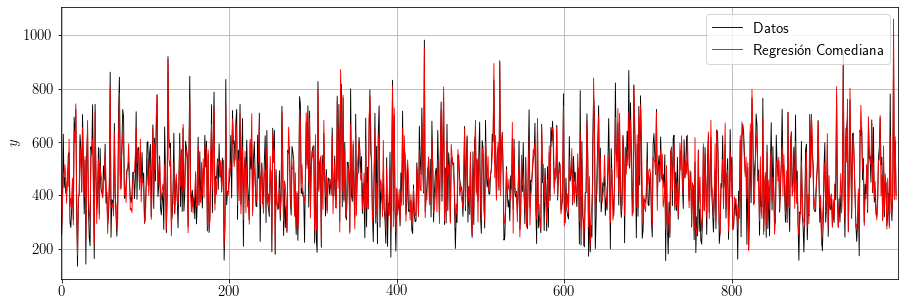

In [379]:
betas_com = cov_linear_regression(data, y, method=0)
plot_multvar_regression(y, data, betas_com, betas, method='Comediana')

Betas:  [[11.37347643  9.96711978 10.89933097  8.81135356  8.18630558  7.10198947
   5.90510442  5.58368799  4.24531171  3.51024728  3.10305227  1.62198841
   0.79183553]] 
 Beta0:  [[49.18104989]]
Dif: 3.4710353183338403


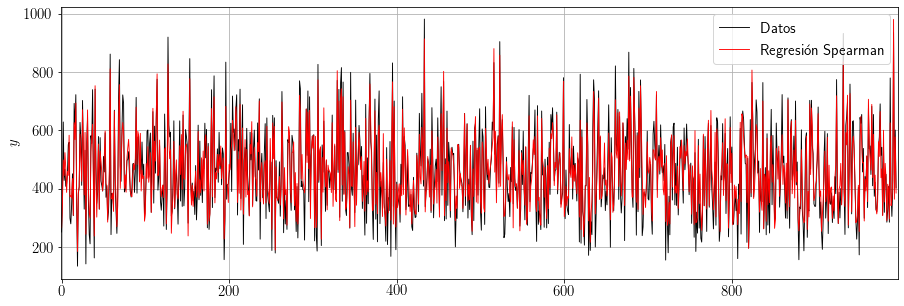

In [380]:
betas_spearman = cov_linear_regression(data, y, method=1)
plot_multvar_regression(y, data, betas_spearman, betas, method='Spearman')

Betas:  [[8.18384478 7.09300168 7.1426319  5.85039646 5.58048814 4.95103418
  3.95438102 3.81385081 2.79239529 2.30885261 2.07435226 1.05108126
  0.41043622]] 
 Beta0:  [[184.6095447]]
Dif: 11.146978648257498


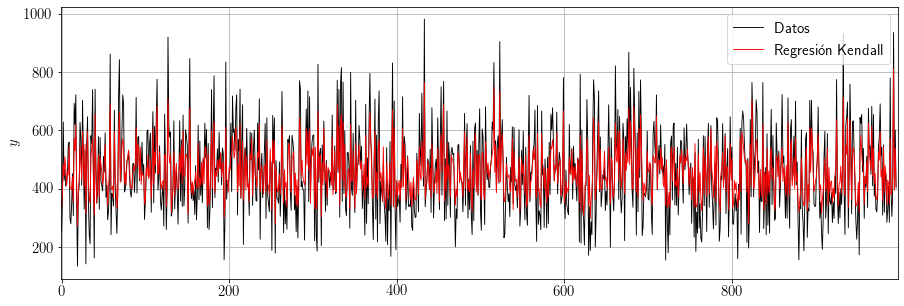

In [381]:
betas_kendall = cov_linear_regression(data, y, method=2)
plot_multvar_regression(y, data, betas_kendall, betas, method='Kendall')

Betas:  [[ 4.78623825  0.69025128  2.67599928  4.17352951  2.97893605  3.38225937
   1.14565166  1.79139149  0.8517589   1.32506688  0.92552627  0.22319576
  -0.04153452]] 
 Beta0:  [[336.08834763]]
Dif: 21.002000008646906


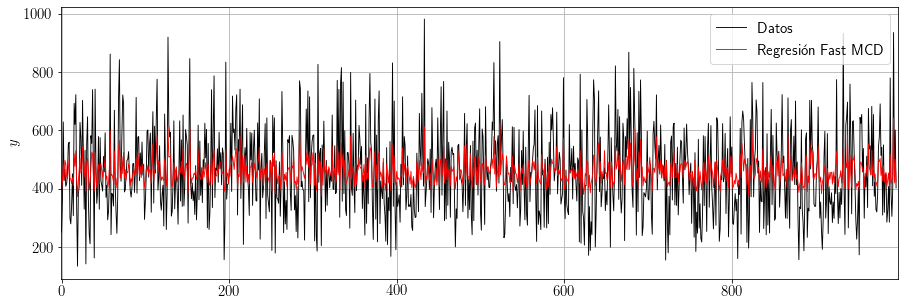

In [382]:
betas_mcd = cov_linear_regression(data, y, method=3)
plot_multvar_regression(y, data, betas_mcd, betas, method='Fast MCD')

Betas:  [[4.23846199 7.25454417 9.80648741 9.29500201 8.86594825 8.10557697
  6.61272901 6.12283501 5.24068048 4.19350731 3.25144649 2.18874922
  0.91333577]] 
 Beta0:  [[17.68788965]]
Dif: 10.079747612790694


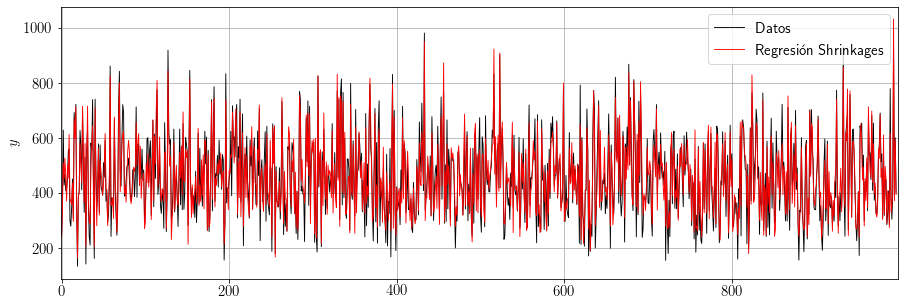

In [383]:
betas_shrink = cov_linear_regression(data, y, method=4)
plot_multvar_regression(y, data, betas_shrink, betas, method='Shrinkages')

Betas:  [[12.05906643 11.24780939 11.39192032  9.94207347  9.3650778   8.01786219
   6.55675134  6.02461687  5.15973271  4.14142369  3.11495684  2.10623546
   0.82034696]] 
 Beta0:  [[-0.67633559]]
Dif: 1.4286607030601992


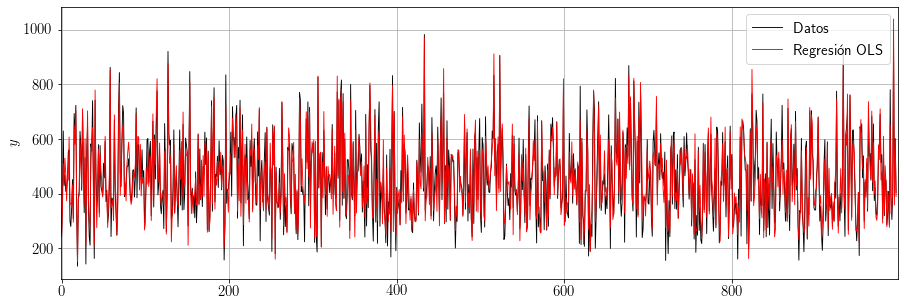

In [384]:
model = sm.OLS(y, data)
results = model.fit()
betas_ols = results.params.reshape((betas_ols.size, 1))
plot_multvar_regression(y, data, betas_ols, betas, method='OLS')